In [1]:
# import python modules
import pyedflib
import numpy as np
import sys
import os
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy import integrate
from scipy import stats
import re
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
matplotlib.pyplot.set_cmap("viridis")
font_manager.findSystemFonts(fontpaths="/usr/share/fonts/", fontext='ttf')                                                                        
font_manager.findfont("Arial") # Test if matplotlib can find the font                                                                             
plt.rcParams['font.family'] = 'Arial'
%matplotlib inline

In [2]:
# define custom functions
def butter_bandpass(x,fl,fh,fs,order):
    fnyq = fs/2
    fl = fl/fnyq
    fh = fh/fnyq
    sos = signal.butter(N=order,Wn=[fl,fh],btype='bandpass',output='sos')
    xf = signal.sosfiltfilt(sos,x)
    return(xf)
# }
def butter_lowpass(x,fl,fs,order):
    fnyq = fs/2
    fl = fl/fnyq
    sos = signal.butter(N=order,Wn=fl,btype='lowpass',output='sos')
    xf = signal.sosfiltfilt(sos,x)
    return(xf)
# }
def butter_highpass(x,fh,fs,order):
    fnyq = fs/2
    fh = fh/fnyq
    sos = signal.butter(N=order,Wn=fh,btype='highpass',output='sos')
    xf = signal.sosfiltfilt(sos,x)
    return(xf)
# }
def load_eegdata(fname):
    print("Loading eeg data from {} ...".format(fname))
    with pyedflib.EdfReader(fname) as f:
        header = f.getHeader()
        filedur = f.getFileDuration()
        nsamples = f.getNSamples()
        nchannels = f.signals_in_file-3
        prefilter = f.getPrefilter(0)
        samplefreqs = f.getSampleFrequencies()[0:-3]
        channels = f.getSignalLabels()[0:-3]
        datetime = f.getStartdatetime()
        dd = np.zeros((nsamples[0],nchannels))
        for i in np.arange(nchannels):
            dd[:,i] = f.readSignal(i)
#        }
#   }
    print("EEG data loading successfull.")
    print("nChannels: {}".format(nchannels))
    print("EEG channel names: {}".format(channels))
    print("EEG data samples: {}".format(nsamples))
    print("File Header: {}".format(header))
    print("Data shape: {}".format(dd.shape))
    return(dd,samplefreqs,channels)
# }

def eegplot(dd,fs,channels):
    fontprop = font_manager.FontProperties(family='Arial',weight='normal',style='normal',size=16)
    nsamples = dd.shape[0]
    nchannels = dd.shape[1]
    t = np.arange(0,nsamples)/fs
    fh, ah = plt.subplots(nrows=nchannels, sharex=True,squeeze = True,figsize=(6,3))
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i in np.arange(0,nchannels):
        ah[i].plot(t,dd[:,i],linewidth=1,color=cycle[i])
        ah[i].spines['right'].set_visible(False)
        ah[i].spines['top'].set_visible(False)
        ah[i].spines['bottom'].set_visible(False)
        ah[i].set_title(channels[i],color=cycle[i],font=fontprop)
        ah[i].set_ylabel("$\mu$V")
#   }
    ah[-1].spines['bottom'].set_visible(True)
    ah[-1].set_xlabel("Time (s)")
    fh.tight_layout()
    fh.subplots_adjust(top=0.9)
    return(fh,ah)
# }

def eegpower(dd,fs,freqbands,epochdur):
#     power spectral density at different epochs using Welch's method
    nchannels = dd.shape[1]
    nsamples = dd.shape[0]
    nsamplesepoch = int(epochdur*fs)
    nperseg = int(nsamplesepoch*0.2)
    nepochs = int(np.floor(nsamples/(epochdur*fs)))
    samples_omit = nsamples-(nepochs*nsamplesepoch)
    print("nepochs: {}".format(nepochs))
    print("nsamples: {}".format(nsamples))
    print("nsamplesepoch: {}".format(nsamplesepoch))
    print("samples omitted {}".format(samples_omit))
    dd2 = dd[0:nepochs*nsamplesepoch,:]
    print(dd.shape)
    dd2.resize((nsamplesepoch,nepochs,nchannels))
    print(dd2.shape)
    powers = np.zeros((nepochs,nchannels,len(freqbands)))
    print(powers.shape)
    freqkeys = list(freqbands.keys())
    for i in range(0,nepochs): # epochs
        for j in range(0,nchannels): # channels
            for k in range(0,len(freqkeys)):
                x = dd2[:,i,j]
                freqband = list(freqbands[freqkeys[k]].values())
                xf = butter_bandpass(x,*freqband,fs,order=2) # bandpass filter the signal
                f,pxx = signal.welch(xf,fs=fs,nperseg=nperseg)
                freq_res = np.mean(np.diff(f))
                ifreqband = [np.where(f > freq)[0][0]-1 for freq in freqband]
                f = f[ifreqband[0]:ifreqband[1]]
                powers[i,j,k] = integrate.simps(pxx[ifreqband[0]:ifreqband[1]],dx=freq_res) # absolute power
                _,pxxf = signal.welch(x,fs=fs,nperseg=nperseg) # compute periodagram on the whole unfiltered signal
                powers[i,j,k] = powers[i,j,k]/integrate.simps(pxxf,dx=freq_res) # compute relative power
#                 print("freqency resolution: {}".format(freq_res))
#                 fh = plt.figure()
#                 ah = fh.add_subplot(111)
#                 ah.plot(f,pxx)
#             }
#         }
#     }
    return(powers)

In [3]:
# load eeg data
datapath_eeg = "/home/anup/goofy/myprojects/eeg/"
fname_eeg = "eeg data.edf"
fullname_eeg = os.path.join(datapath_eeg,fname_eeg)
eeg,fs,channels = load_eegdata(fullname_eeg)

Loading eeg data from /home/anup/goofy/myprojects/eeg/eeg data.edf ...
EEG data loading successfull.
nChannels: 44
EEG channel names: ['EEG Fp1-Ref', 'EEG F7-Ref', 'EEG T3-Ref', 'EEG T5-Ref', 'EEG O1-Ref', 'EEG F3-Ref', 'EEG C3-Ref', 'EEG P3-Ref', 'EEG A1-Ref', 'EEG Fz-Ref', 'EEG Cz-Ref', 'EEG Fp2-Ref', 'EEG F8-Ref', 'EEG T4-Ref', 'EEG T6-Ref', 'EEG O2-Ref', 'EEG F4-Ref', 'EEG C4-Ref', 'EEG P4-Ref', 'EEG A2-Ref', 'EEG Fpz-Ref', 'EEG Pz-Ref', 'EEG LT EMG1-Ref', 'EEG LT EMG2-Ref', 'EEG RT EMG1-Ref', 'EEG RT EMG2-Ref', 'EEG LT RESP-Ref', 'EEG RT RESP-Ref', 'EEG X7-Ref', 'EEG X8-Ref', 'EEG X9-Ref', 'EEG X10-Ref', 'EEG X11-Ref', 'EEG X12-Ref', 'EEG X13-Ref', 'EEG X14-Ref', 'EEG X15-Ref', 'EEG X16-Ref', 'EEG ECG-Ref', 'EEG X18-Ref', 'EEG DC1-Ref', 'EEG DC2-Ref', 'EEG DC3-Ref', 'EEG DC4-Ref']
EEG data samples: [7233792 7233792 7233792 7233792 7233792 7233792 7233792 7233792 7233792
 7233792 7233792 7233792 7233792 7233792 7233792 7233792 7233792 7233792
 7233792 7233792 7233792 7233792 723379

[256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256
 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256
 256 256 256 256 256 256 256 256]
(7233792, 44)


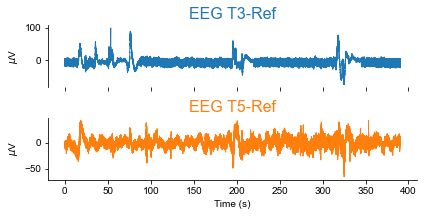

In [4]:
# visualize eeg channels
print(fs)
print(eeg.shape)
fh,ah = eegplot(eeg[2000000:2100000,2:4],fs[0],channels[2:4])
plt.show()

In [5]:
# Define EEG frequency bands
freqbands = {"delta":{"low":0.5,"high":4},"theta":{"low":4,"high":8},"alpha":{"low":8,"high":13},"beta":{"low":13,"high":30},\
             "gamma":{"low":30,"high":50},"total":{"low":0.5,"high":50}}

[0.5, 50]
[0.5, 50]
EEG T3-Ref 2
(501, 117) 8.930238508457428e-19 104.63015592238202
Time resolution: 3.41796875 0.00390625
Max time:  398.4375
(103000,) 256 (103000,)


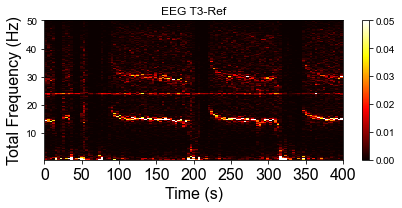

In [6]:
# f,t,Sxx = signal.spectrogram(xf, fs=fs[2],nperseg=200,axis=0)
bandname = "total"
bandlabels = {"beta":r"$\beta$","alpha":r"$\alpha$","delta":r"$\delta$","gamma":r"$\delta$","theta":r"$\theta$","total":"Total"}
freqband = list(freqbands[bandname].values())
print(freqband)
channel = channels[2]
channelid = [i for i,item in enumerate(channels) if item==channel][0]
print(freqband)
print(channel,channelid)
f,t,Sxx = signal.spectrogram(butter_bandpass(eeg[2000000:2103000,channelid],*freqband,fs[0],order=3), fs=fs[0],nperseg=1000,axis=0)
#f,t,Sxx = signal.spectrogram(eeg[:,channelid], fs=fs[0],nperseg=50000,axis=0)
print(Sxx.shape,np.min(Sxx),np.max(Sxx))
print("Time resolution:", np.diff(t).mean(),1/fs[0])
print("Max time: ",np.max(t))
Sxx = Sxx/np.max(Sxx)
plt.close('all')
fp_label = font_manager.FontProperties(family='Arial',weight='normal',style='normal',size=16)
fh = plt.figure(figsize=(6,3))
ah = fh.add_subplot(111)
ph=ah.pcolormesh(t, f, Sxx,shading='nearest',cmap='hot',vmin=0,vmax=.05)
ah.set_title(channels[channelid])
#ylabel = "".join((bandlabels[bandname]," [",str(freqbands[bandname]["low"]),"-",str(freqbands[bandname]["high"])," Hz] "," power"," (dbHz$^{-1}$)"))
ylabel = "".join((bandlabels[bandname]," Frequency (Hz)"))
#print(ylabel)
xticks = [0,50,100,150,200,250,300,350,400]
ah.set_xticks(xticks)
ah.set_xticklabels(xticks,font=fp_label)
ah.set_ylabel(ylabel,font=fp_label)
ah.set_xlabel("Time (s)",font=fp_label)
yticks = ah.get_yticks()
#ah.set_yticklabels(yticks,font=fp_label)
fh.colorbar(ph, ax=ah)
ah.set_ylim(freqband)
ah.set_ylim([freqbands[bandname]["low"],freqbands[bandname]["high"]])
d = eeg[2000000:2103000,channelid]
td = np.arange(0,len(d))/fs[channelid]
print(d.shape,fs[channelid],td.shape)
# ah.plot(td,-d)
fh.tight_layout()

/home/anup/goofy/myprojects/eeg/glucose data.xls


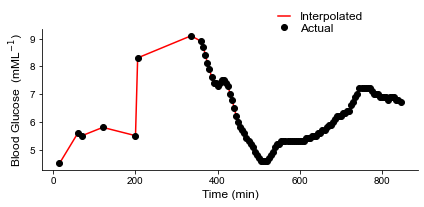

In [7]:
# load glucose data
datapath_glu = "/home/anup/goofy/myprojects/eeg/"
fname_glu = "glucose data.xls"
fullname_glu = os.path.join(datapath_glu,fname_glu)
print(fullname_glu)
glu = pd.read_excel(fullname_glu)
#print(glu)
f  = interpolate.interp1d(glu["epoch"],glu["glc_all"],kind='linear')
epochs_new = np.arange(3,169,1/60)
glu_new = f(epochs_new)
glu_intrp = pd.DataFrame({"epoch":epochs_new,"glu":glu_new})
# ---------------------------
fp_label = font_manager.FontProperties(family='Arial',weight='normal',style='normal',size=12) 
fh = plt.figure(figsize=(6,3))
ah = fh.add_subplot(111)
# ah.plot(epochs_new,glu_new,'o')
ah.plot(glu_intrp["epoch"]*5,glu_intrp["glu"],'-',color="red",label="Interpolated")
ah.plot(glu["epoch"]*5,glu["glc_all"],'o',color="black",label="Actual")
ah.set_xlabel("Time (min)",font=fp_label)
ah.set_ylabel("Blood Glucose  (mML$^{-1}$)",font=fp_label)
ah.spines["right"].set_visible(False)                                                                                                                                     
ah.spines["top"].set_visible(False) 
fontprop1 = font_manager.FontProperties(family='Arial',weight='normal',style='normal',size=12)                                                                             
lh = ah.legend(frameon=False,loc="center",bbox_to_anchor=(0.6,0.8,0.1,0.5),prop=fontprop1,labelspacing=0.1,markerscale=1,mode='expand',handlelength=1) 
fh.tight_layout()
# ah.set_xlim([0,100
#print(glu_intrp)

In [8]:
epochdur = 300
powers=eegpower(eeg,fs[0],freqbands,epochdur)
print(powers.shape)

nepochs: 94
nsamples: 7233792
nsamplesepoch: 76800
samples omitted 14592
(7233792, 44)
(76800, 94, 44)
(94, 44, 6)
(94, 44, 6)


(94, 44, 6)
dict_keys(['delta', 'theta', 'alpha', 'beta', 'gamma', 'total'])
alpha


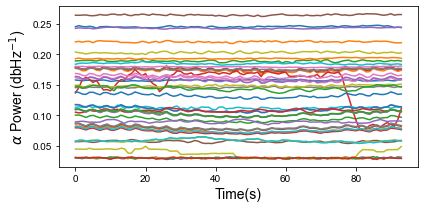

In [9]:
# plot power 
print(powers.shape)
plt.close('All')
bandid = 2
print(freqbands.keys())
bandname = list(freqbands.keys())[bandid]
print(bandname)
bandlabels = {"beta":r"$\beta$","alpha":r"$\alpha$","delta":r"$\delta$","gamma":r"$\delta$","theta":r"$\theta$"}

fh = plt.figure(figsize=(6,3))
ah = fh.add_subplot()
fp_label = font_manager.FontProperties(family='Arial',weight='normal',style='normal',size=14)
ah.plot(powers[:,:,bandid])

ylabel = "".join((bandlabels[bandname],r" Power (dbHz$^{-1}$)"))
ah.set_ylabel(ylabel,font=fp_label)
ah.set_xlabel("Time(s)",font=fp_label)
fh.tight_layout()
plt.show()

In [10]:
# clip data to align the two datasets
# eeg starts at epoch 24
print(glu_intrp.shape)
glu_intrp2 = glu_intrp[(glu_intrp["epoch"]>23) & (glu_intrp["epoch"]<(24+94))].reset_index(drop=True)
# glu_intrp2["epoch"] = glu_intrp2["epoch"]-24
print(glu_intrp2.shape)
print(powers.shape)
# powers = powers[0,:,:]

(9960, 2)
(5700, 2)
(94, 44, 6)


['EEG Cz-Ref', 'EEG Fp2-Ref', 'EEG F8-Ref', 'EEG T4-Ref', 'EEG T6-Ref', 'EEG O2-Ref', 'EEG F4-Ref', 'EEG C4-Ref', 'EEG P4-Ref', 'EEG A2-Ref']
delta
EEG T3-Ref, band: $\delta$


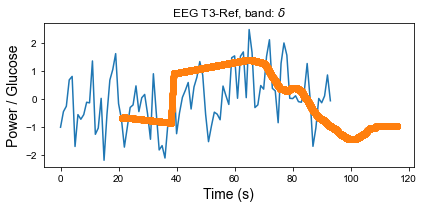

In [11]:
plt.close('all')
fh = plt.figure(figsize=(6,3))
ah = fh.add_subplot(111)
print(channels[10:20])
channelid = 2
bandid = 0
y1 = (powers[:,channelid,bandid]-powers[:,channelid,bandid].mean())/powers[:,channelid,bandid].std()
y2 = (glu_intrp2["glu"]-glu_intrp2["glu"].mean())/glu_intrp2["glu"].std()
bandname = list(freqbands.keys())[bandid]
ah.plot(np.arange(0,powers.shape[0]),y1)
#ah.plot(np.arange(0,powers.shape[0]),powers[:,10:22,:].mean(axis=1).mean(axis=1)*40-8)
ah.plot(glu_intrp2["epoch"]-2,y2,'-o')
# powers[20,:]
print(bandname)
title = "".join((channels[channelid],", band: ",bandlabels[bandname]))
print(title)
ah.set_title(title)
fp_label = font_manager.FontProperties(family='Arial',weight='normal',style='normal',size=14)
ah.set_xlabel("Time (s)",font=fp_label)
ah.set_ylabel("Power / Glucose",font=fp_label)
fh.tight_layout()
plt.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 5700 and the array at index 1 has size 94

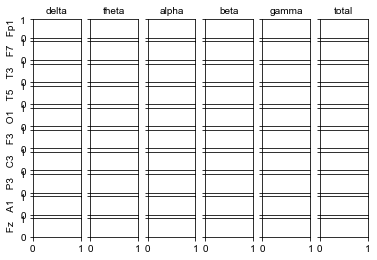

In [12]:
# display correlation between power in EEG channels and glucose levels
plt.close('all')
x = glu_intrp2["glu"].to_numpy()
x = (x-x.mean())/x.std() # z-score data
fh, ah = plt.subplots(nrows=10, ncols=6,sharex=True,sharey=True,squeeze = True)
[ah.set_title(list(freqbands.keys())[i],fontsize=10) for i,ah in enumerate(ah[0,:])] # set column labels
[ah.set_ylabel(re.search("\W.*\-",channels[i])[0][0:-1],fontsize=10) for i,ah in enumerate(ah[:,0])] # set row labels
for i in range(0,10):
    for j in range(0,6): 
        y = powers[:,i,j]
        y = (y-y.mean())/y.std() # z-score data
        slope, intercept, rvalue, pvalue, std_err = stats.linregress(x,y)
        ah[i,j].plot(x,y,'o',markersize=1,linewidth=1,color='grey')
        ah[i,j].spines['right'].set_visible(False)
        ah[i,j].spines['top'].set_visible(False)
        ah[i,j].spines['bottom'].set_visible(False)
        ah[i,j].plot(x,x*slope + intercept,color="blue",linewidth=1)
        if (pvalue <0.05):
            ah[i,j].text(-1.5,3,"".join(("R: ",str(np.round(rvalue,1))," P: ",str(np.round(pvalue,2)))),
                         fontsize=8,color="green")
        else:
            ah[i,j].text(-1.5,3,"".join(("R: ",str(np.round(rvalue,1))," P: ",str(np.round(pvalue,2)))),
                         fontsize=8,color="red") 
        # }   
    # }
# }
plt.tight_layout()
plt.show()

In [ ]:
print(re.search("\W.*\-",channels[0])[0][0:-1])

In [ ]:
# find correlations using a linear regression model
rvalues = np.zeros((44,6))
pvalues = np.zeros((44,6))
x = glu_intrp2["glu"].to_numpy()
for i in range(0,44):
    for j in range(0,6):  
        y = powers[:,i,j]
        slope, intercept, rvalues[i,j], pvalues[i,j], std_err = stats.linregress(x,y)
# convert results to a dataframe for easy extraction of specific values
rvalues = pd.DataFrame(data=rvalues,index = channels,columns=list(freqbands.keys()))
pvalues = pd.DataFrame(data=pvalues,index = channels,columns=list(freqbands.keys()))
# print(list(freqbands.keys()))
# print(pvalues.head)

In [ ]:
plt.close('all')
fh = plt.figure()
ah = fh.add_subplot(111)
x= np.arange(-0.5,44,1)
y = np.arange(-0.5,6,1)
z = rvalues
# z = pvalues
print(x.shape,y.shape,z.shape)
ph = ah.pcolormesh(x,y,z.T,cmap='hot',vmin=-0.5,vmax=0.5)
ah.set_title("Correlation $(\itR)$ between EEG power and blood glucose levels\n")
ah.set_xlabel("EEG Channels",fontsize=16)
ah.set_ylabel("EEG frequency bands",fontsize=16)
yticks = list(freqbands.keys())
ah.set_yticks(np.arange(0,6))
ah.set_yticklabels(yticks)
ch = fh.colorbar(ph)
ch.set_label("Corerlation ($\itR$)")
print(yticks)
print(channels[24])
plt.tight_layout()

In [ ]:
plt.close('all')
fh = plt.figure(figsize=(6,5))
ah = fh.add_subplot(111)
x= np.arange(-0.5,44,1)
y = np.arange(-0.5,6,1)
# z = rvalues*rvalues
z = pvalues
print(x.shape,y.shape,z.shape)
ph = ah.pcolormesh(x,y,z.T,cmap='hot',vmin=0,vmax=0.05)
ah.set_title("Significance for correlation $(\itR)$ between EEG power & blood glucose\n")
ah.set_xlabel("EEG Channels",fontsize=16)
ah.set_ylabel("EEG frequency bands",fontsize=16)
# ah.yaxis.set_label_coords(-0.1,1)
yticks = list(freqbands.keys())
ah.set_yticks(np.arange(0,6))
ah.set_yticklabels(yticks)
ch = fh.colorbar(ph)
ch.set_label("Significance ($\itP_{value}$)")
plt.tight_layout()

In [ ]:
plt.close('all')
glucose = glu_intrp2["glu"].to_numpy()
glucose = (glucose - glucose.mean())/glucose.std()
channelid = 6
channelname = channels[channelid]
print(channelname)
gamma_power = powers[:,channelid,4]
gamma_power = (gamma_power - gamma_power.mean())/gamma_power.std()
t = glu_intrp2["epoch"].to_numpy()
# t = t-t[0]
t = t
fh = plt.figure()
ah = fh.add_subplot(111)
ah.plot(t,glucose,label="Blood glucose")
ah.plot(t,gamma_power,label= "".join((channelname," Gamma power")))
title = "".join(("Correlation between ", channelname, " Gamma power & blood glucose\n"))
ah.set_title(title)
ah.set_xlabel("Time (min)")
ah.set_ylabel("Z-score values",fontsize=18)
ah.legend()
ah.spines["right"].set_visible(False)                                                                                                                                     
ah.spines["top"].set_visible(False) 
plt.tight_layout()

In [ ]:
# find correlations using a linear regression model
print(powers.shape)
corrs = np.zeros((44,6,187))
x = glu_intrp2["glu"].to_numpy()
for i in range(0,44):
    for j in range(0,6):  
        y = powers[:,i,j]
        corrs[i,j,:] = signal.correlate(x,y,mode="full")
#         corr_lags = signal.correlation_lags(len(y), len(x))
print(corrs.shape)
lag = corrs.argmax() - (len(x) - 1)
print(lag)
plt.close('all')
fh = plt.figure()
ah = fh.add_subplot(111)
ah.plot(corrs.mean(axis=1)[0,:])

In [ ]:
import arviz as az